In [494]:
import numpy as np
import pandas as pd
from scipy import sparse
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

### playground

In [516]:
df = pd.read_csv("./data/lastfm_user_scrobbles.csv")
df.scrobbles.describe()


count     92792.000000
mean        745.521521
std        3752.146187
min           1.000000
25%         107.000000
50%         260.000000
75%         614.000000
max      352698.000000
Name: scrobbles, dtype: float64

In [525]:
scrobsdf = pd.read_csv("./data/lastfm_user_scrobbles.csv")
df=scrobsdf
df["rating"] = df.scrobbles / df.groupby("user_id").scrobbles.transform('sum').to_numpy()
df.rating = np.log(df.rating) + 12
df[df["user_id"] == 123]

,user_id,artist_id,scrobbles,rating
6014,123,1431,2566,9.401157
6015,123,2189,2254,9.271515
6016,123,9033,1718,8.999970
6017,123,5545,1597,8.926936
6018,123,3426,1574,8.912429
6019,123,13258,1307,8.726543
6020,123,671,1140,8.589837
6021,123,10902,952,8.409619
6022,123,10236,831,8.273683
6023,123,9722,812,8.250554


In [495]:
scrobsdf = pd.read_csv("./data/lastfm_user_scrobbles.csv")
scrobs = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
scrobs[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["scrobbles"]
scrobs = scrobs.tocsr()
# scrobs.sum(axis=1)

                  0
count  92723.000000
mean       9.612274
std        1.375519
min        0.211468
25%        8.860118
50%        9.808049
75%       10.561727
max       12.000000


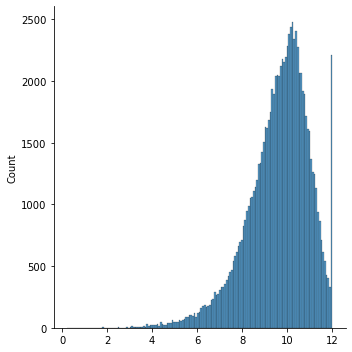

In [519]:
scrobsdf = pd.read_csv("./data/lastfm_user_scrobbles.csv")
scrobs = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
scrobs[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["scrobbles"]
scrobs = scrobs.tocsr()

def unskew(scrobs):
#     denom_max = np.repeat(scrobs.sum(axis=1).A, scrobs.getnnz(axis=1))
#     return scrobs.data/denom_max
    
    denom_max = np.repeat(scrobs.max(axis=1).A, scrobs.getnnz(axis=1))
    denom_min = np.repeat(scrobs.min(axis=1).A, scrobs.getnnz(axis=1))
    return (scrobs.data - denom_min)/(denom_max - denom_min)

scrobs.data = unskew(scrobs)
scrobs.data=np.log(scrobs.data) + 12
print(pd.DataFrame(scrobs.data).describe())
sns.displot((scrobs.data))

In [502]:
scrobs.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

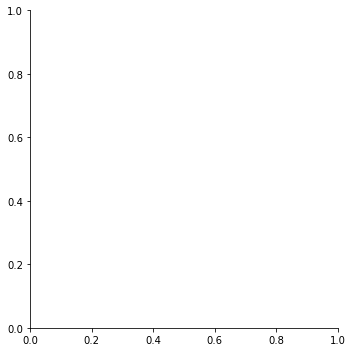

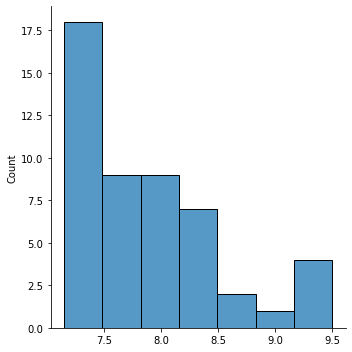

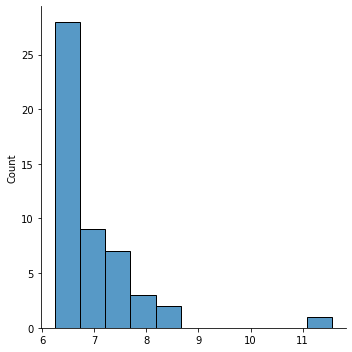

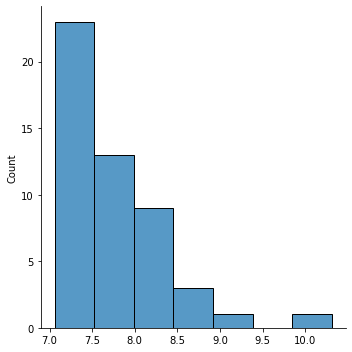

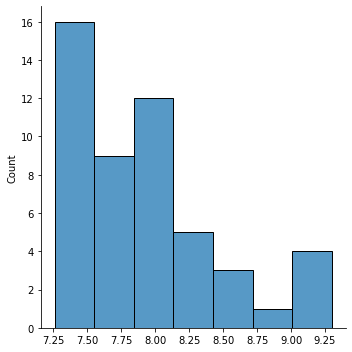

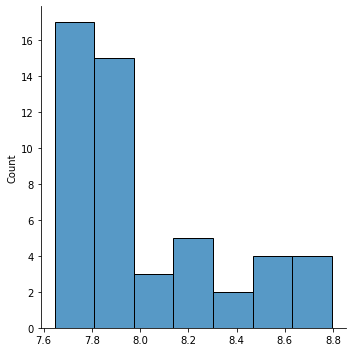

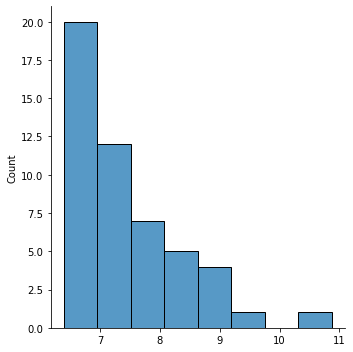

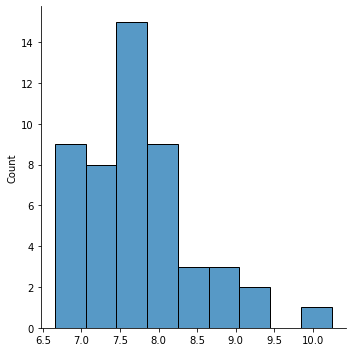

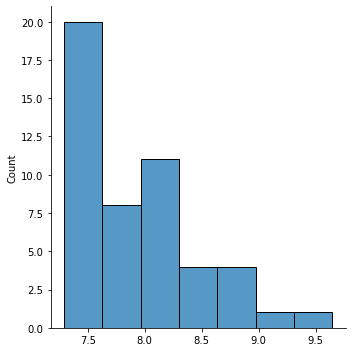

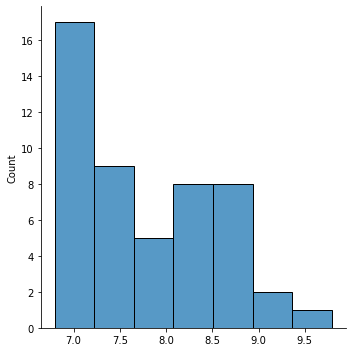

In [501]:
for i in range(10):
    sns.displot(scrobs[i].data)

### Data reading

In [404]:
scrobsdf = pd.read_csv("./data/lastfm_user_scrobbles.csv")

In [387]:
df = scrobsdf
df.scrobbles.describe()

count     92792.000000
mean        745.521521
std        3752.146187
min           1.000000
25%         107.000000
50%         260.000000
75%         614.000000
max      352698.000000
Name: scrobbles, dtype: float64

In [388]:
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

In [389]:
gmax = df.groupby("user_id").scrobbles.transform('max')
gmin = df.groupby("user_id").scrobbles.transform('min')
df.scrobbles = (df.scrobbles - gmin)/(gmax-gmin)

count    92761.000000
mean         0.122915
std          0.201110
min          0.000000
25%          0.010638
50%          0.042693
75%          0.136679
max          1.000000
Name: scrobbles, dtype: float64


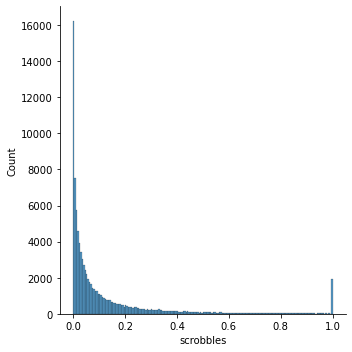

In [390]:
normlog = df.scrobbles#normalize(np.log(df.scrobbles))
print(normlog.describe())
sns.displot(normlog)

In [391]:
artdf = pd.read_csv("./data/lastfm_artist_list.csv")
artdf = artdf.set_index("artist_id")

In [392]:
artdf[artdf["artist_name"].str.contains("ollier")]

,artist_name
artist_id,


### Make scipy csr sparse matrix from lil with users as rows and artist as column with # scrobbles as value

In [393]:
scrobs = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
scrobs[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["scrobbles"]
scrobs = scrobs.tocsr()

### Change #listens to ratings

This is to make collaborative filtering work, rather than values like 100, 90, 80 for the top 3 artists of a user, these would be scores representing how they might rate those artists. 

1. Divide by max
    * result: 1, .9, .8
    * ranking of a user's artists
    * 
2. Divide by sum
    * result: 0.37, 0.33, 0.29
    * proportion of total listens that artist occupies
    * users with many artists have lower ratings
    * ranking doesn't affect rating, so 

In [403]:
pd.DataFrame(unskew(scrobs)).describe()

,0
count,89346.000000
mean,0.563846
std,0.101700
min,0.500002
25%,0.506468
50%,0.523271
75%,0.571429
max,1.000000


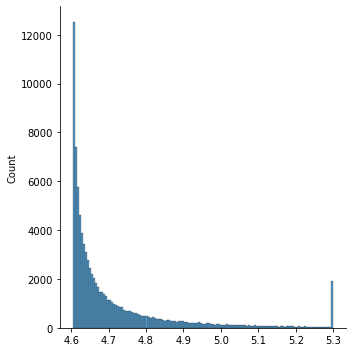

In [399]:
sns.displot(np.log(scrobs.data))

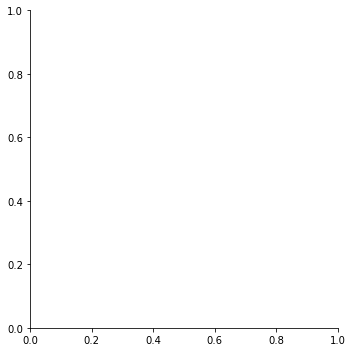

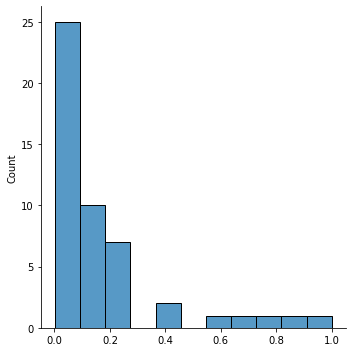

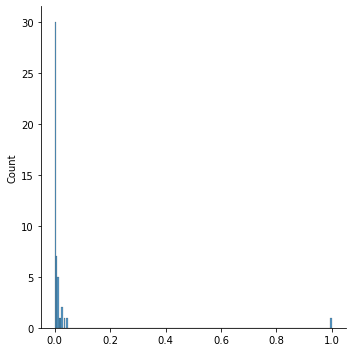

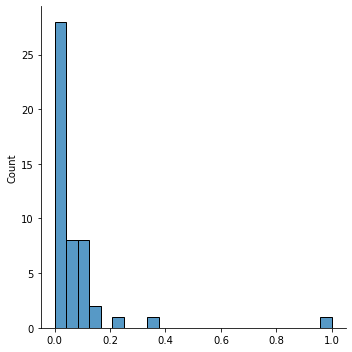

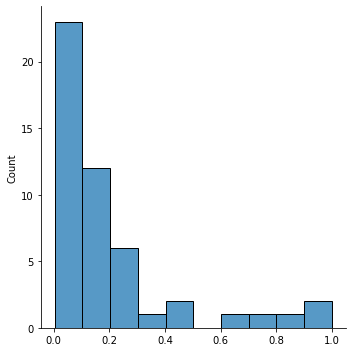

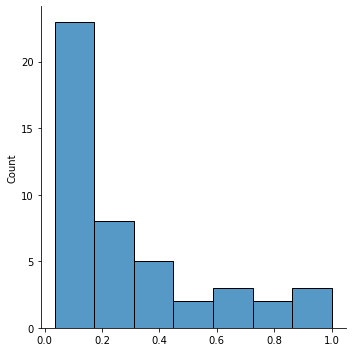

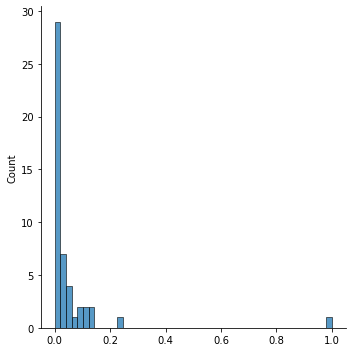

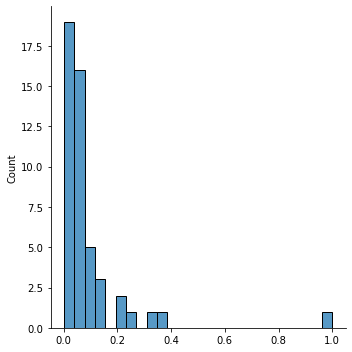

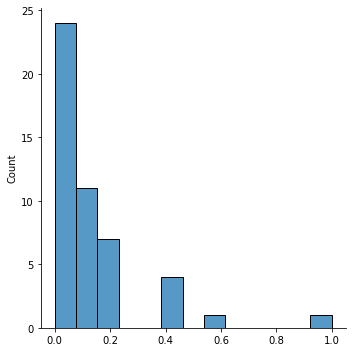

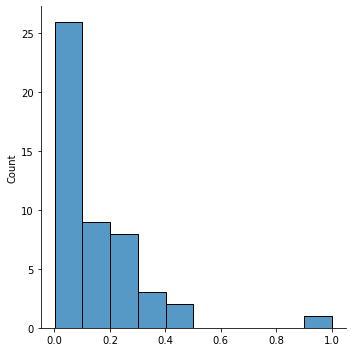

In [356]:
for i in range(10):
    sns.displot(scrobs[i].data)

### ----PLAYGROUND----

In [76]:
artdf.loc[stats.mode(scrobs.argmax(axis=1).A.T[0]).mode[0]]

artist_name    Britney Spears
Name: 2381, dtype: object

In [88]:
# edges=[[1,2],[3,4],[1,5],[5,3]]
toy = np.array([[1,1,2,3,3], [2,3,1,1,2]])
toydata = np.array([100,10,200,300,30])
lil = sparse.lil_matrix((3,3))
lil[toy[0,:]-1,toy[1,:]-1] = toydata
csr = lil.tocsr()
csr.getnnz(axis=1)
csr.max(axis=1).A
denom = np.repeat(csr.max(axis=1).A,csr.getnnz(axis=1))
csr.data = csr.data/denom
len(csr.data)

5

In [97]:
csr.data[csr.data < 1] = 0
len(csr.data)
csr.eliminate_zeros()
csr.data

array([1., 1., 1.])